# Antimicrobial peptide (AMP) recognition using deep learning

[Peptide](https://en.wikipedia.org/wiki/Peptide) are short chains of [amino acid](https://en.wikipedia.org/wiki/Amino_acid) linked by peptide bonds. Among them, [antimicrobial peptides (AMP)](https://en.wikipedia.org/wiki/Antimicrobial_peptides) are part of the innate immune response found among all classes of life, and have been demonstrated to kill Gram negative and Gram positive bacteria, enveloped viruses, fungi and even transformed or cancerous cells. <br>
One of the research interest in our lab is to understand the mechanism of the peptide and lipid membrane interaction. We are especially interested in AMP peptide and lipid membrane interaction, and have studied many of them to understand the mechanism how AMP peptides kill bacteria by forming different types of pores on bacterias's membrane ([Toroidal vs. Barrel Stave Model](https://hwhuang.rice.edu/toroidalModelVsBarrelStave.html)). <br>

## What we want to achieve in this work?
There are two goals we want to achieve using DNN:<br>
(1) To recognize if a given peptide is a AMP peptide or not<br>
(2) To classfy what kind of pores (Toroidal or Barrel Stave) will be formed on bacteria membrane for a given AMP peptide. <br>
We're using deep learning to recognize AMP peptides inspired by the work of Daniel Veltri (see reference below). 

<img src="https://www.dveltri.com/ascan/images/DNNv2.png" width="900">
Image from Daniel Veltri (see reference below)<br>

In [2]:
#import necessay module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import losses
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, LSTM, MaxPooling1D, BatchNormalization, Bidirectional, Conv1D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, confusion_matrix, f1_score

## Data loading
The sequences of AMP and non-AMP peptides were downloaded from database of Daniel Veltri. There are 1778 samples for each group.  

In [3]:
#loading sequences of AMP peptide 
files=['AMP.eval.fa', 'AMP.te.fa', 'AMP.tr.fa']
names=['eval', 'te', 'tr']

for file, name in zip(files, names):
    globals()['amp_array_' + name] =[]
    with open(file) as fp:  
        for cnt, line in enumerate(fp):
            line=line.strip('\n')
            if line[0]!='>':
                #padding X(unknown) in front of each peptide sequence to make uniform length 200
                while len(line)<200:
                    line='X'+line
                globals()['amp_array_' + name].append(line)
                
amp_array_all = amp_array_eval + amp_array_te + amp_array_tr
print('Number of AMP samples: {}'.format(len(amp_array_all)))
print('One AMP sequence (pad X at beginning to make its length 200): ')
print(amp_array_all[np.random.randint(len(amp_array_all))])

Number of AMP samples: 1778
One AMP sequence (pad X at beginning to make its length 200): 
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGILDTLKNLAISAAKGAAQGLVNKASCKLSGQC


In [4]:
#loading sequences of non-AMP peptide 
files=['DECOY.eval.fa', 'DECOY.te.fa', 'DECOY.tr.fa']
names=['eval', 'te', 'tr']

for file, name in zip(files, names):
    globals()['decoy_array_' + name] =[]
    with open(file) as fp:  
        for cnt, line in enumerate(fp):
            line=line.strip('\n')
            if line[0]!='>':
                #padding X(unknown) in front of each peptide sequence to make uniform length 200
                while len(line)<200:
                    line='X'+line
                globals()['decoy_array_' + name].append(line)
                
decoy_array_all = decoy_array_eval + decoy_array_te + decoy_array_tr
print('Number of non-AMP samples: {}'.format(len(decoy_array_all)))
print('One non-AMP sequence (pad X at beginning to make its length 200):')
print(decoy_array_all[np.random.randint(len(decoy_array_all))])

Number of non-AMP samples: 1778
One non-AMP sequence (pad X at beginning to make its length 200):
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLSQYLHAEVIPNFVKSLSEPS


Let's take a look on the amino acid histogram for AMP and non-AMP.  The first look on these graphs tells us AMP is more likely to have Cysteine (C) in the sequence than non-AMP

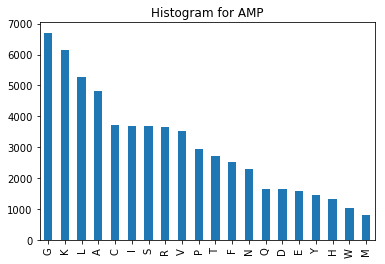

In [5]:
#plot amino acid (AA) histogram for AMP
temp_amp = []
for string in (amp_array_all):
    string_list = list(string)
    for i in range(len(string_list)):
        if string_list[i] != 'X':
            temp_amp.append(string_list[i])

title = 'Histogram for AMP'
pd.Series(temp_amp).value_counts().plot('bar', title=title)

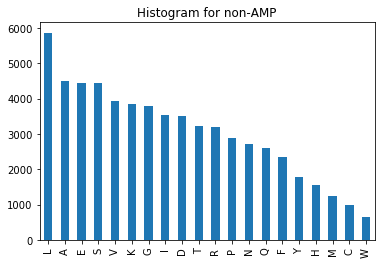

In [6]:
#plot amino acid (AA) histogram for non-AMP
temp_decoy = []
for string in (decoy_array_all):
    string_list = list(string)
    for i in range(len(string_list)):
        if string_list[i] != 'X':
            temp_decoy.append(string_list[i])

title = 'Histogram for non-AMP'
pd.Series(temp_decoy).value_counts().plot('bar', title=title)

In [7]:
#prepare merged inputs and labe for deep neural network
input_array_all_X = amp_array_all + decoy_array_all
input_array_all_Y = np.concatenate([np.ones((len(amp_array_all),1), dtype=np.int8), np.zeros((len(decoy_array_all),1), dtype=np.int8)])

print('Length of input: {}'.format(len(input_array_all_X)))
print('Length of label: {}'.format(len(input_array_all_Y)))

Length of input: 3556
Length of label: 3556


In [8]:
#create dictionary mapping 20 amino acid to different integer and mapping unknow X to 0
mapping1 = ['X','A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
mapping2 = [i for i in range(21)]
mapping = {mapping1[i]:mapping2[i] for i in range(21)}
mapping

{'X': 0,
 'A': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'V': 18,
 'W': 19,
 'Y': 20}

In [9]:
#mapping 21 different amino acid to 21 intergers:
input_array_all_X2 = [0] * len(input_array_all_X)
for i in range(len(input_array_all_X)):
    tmp1=input_array_all_X[i]
    tmp2=[]
    for j in range(len(tmp1)):
        tmp2.append(mapping[tmp1[j]])
    input_array_all_X2[i] = np.array(tmp2)
input_array_all_X2 = np.array(input_array_all_X2)

input_array_all_X2 = pd.DataFrame(input_array_all_X2)
input_array_all_Y  = pd.DataFrame(input_array_all_Y)


In [10]:
#check the encoding for one peptide 
randint = np.random.randint(len(input_array_all_X))
print('Mapping peptide sequence:')
print(input_array_all_X[randint])
print('to')
print(input_array_all_X2.iloc[randint].values)


Mapping peptide sequence:
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXWRSLGRTLLRLSHALKPLARRSGW
to
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 19 15 16 10  6 15 17 10 10 15 10 16  7  1 10  9
 13 10  1 15 15 16  6 19]


In [11]:
#split data into training data (2/3 of all data) and test data (1/3 of all data)
X_train, X_test, Y_train, Y_test = train_test_split(input_array_all_X2, input_array_all_Y, test_size=0.33, random_state=36)

print('X_train.shape = {}'.format(X_train.shape))
print('X_test.shape = {}'.format(X_test.shape))


X_train.shape = (2382, 200)
X_test.shape = (1174, 200)


## Build a single DNN
Let's build a single DNN to take a quick on the result. 

In [35]:
#build a single deep neural network model
#the DNN uses a mix of convolutional (Conv1D), recurrent long short-term memory (LSTM), and dense layers. 
model0 = Sequential()
#input vectors X are fed to an embedding layer of length 128
model0.add(Embedding(21, 128, input_length=200))
#Conv1D layer comprised of 64 filters
model0.add(Conv1D(filters=64, kernel_size=16, strides=1, padding='same', activation='relu'))
#MaxPooling1D layer of size 5 to down-sample
model0.add(MaxPooling1D(5))
#LSTM layer with 128 units
model0.add(LSTM(128, return_sequences = False, unroll=True, stateful=False))
#few layers of dense layer
model0.add(Dense(64, activation='relu'))
model0.add(Dense(32, activation='relu'))
model0.add(Dense(16, activation='relu'))
#last dense layer with sigmoid activation
model0.add(Dense(1, activation='sigmoid'))
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 128)          2688      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 200, 64)           131136    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 40, 64)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
__________

In [36]:
#fit data into single DNN model
optimizer = Adam(lr=0.001)
model0.compile(optimizer=optimizer, loss=losses.mean_squared_error, metrics=["acc"])

history0 = model0.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test))


Train on 2382 samples, validate on 1174 samples
Epoch 1/15
2382/2382 [==============================] - 41s 17ms/step - loss: 0.1469 - acc: 0.7960 - val_loss: 0.0828 - val_acc: 0.8893
Epoch 2/15
2382/2382 [==============================] - 17s 7ms/step - loss: 0.0893 - acc: 0.8829 - val_loss: 0.0818 - val_acc: 0.8893
Epoch 3/15
2382/2382 [==============================] - 8s 3ms/step - loss: 0.0756 - acc: 0.9064 - val_loss: 0.0721 - val_acc: 0.8995
Epoch 4/15
2382/2382 [==============================] - 5s 2ms/step - loss: 0.0633 - acc: 0.9215 - val_loss: 0.0744 - val_acc: 0.8969
Epoch 5/15
2382/2382 [==============================] - 4s 2ms/step - loss: 0.0545 - acc: 0.9324 - val_loss: 0.0703 - val_acc: 0.9123
Epoch 6/15
2382/2382 [==============================] - 4s 2ms/step - loss: 0.0485 - acc: 0.9391 - val_loss: 0.0742 - val_acc: 0.9089
Epoch 7/15
2382/2382 [==============================] - 4s 2ms/step - loss: 0.0472 - acc: 0.9421 - val_loss: 0.0708 - val_acc: 0.9114
Epoch 8/15


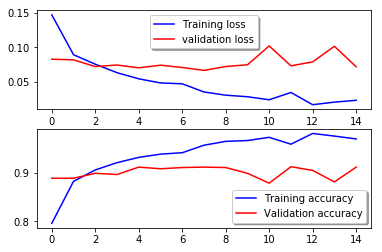

In [37]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history0.history['loss'], color='b', label="Training loss")
ax[0].plot(history0.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history0.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history0.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [38]:
#define function to calculate different evaluation scores: sensitivity (SENS), specifity (SPEC), accuracy (ACC), and F1 score
def evaluation_scores(true_, pred_):
    tn, fp, fn, tp = confusion_matrix(true_, pred_).ravel()
    print('confusion_matrix:')
    print(confusion_matrix(true_, pred_))
    print('')

    sens = tp/ (tp+fn) * 100
    spec = tn/ (tn+fp) * 100
    acc  = (tp+tn)/ (tp+fp+tn+fn) *100
    f1score = f1_score(true_, pred_)

    print('SENS: {:.3f} %'.format(sens))
    print('SPEC: {:.3f} %'.format(spec))
    print('ACC : {:.3f} %'.format(acc))
    print('F1 score: {:.3f}'.format(f1score))

In [41]:
#calculate the score for the test dataset using single DNN model
predict = model0.predict(X_test)
predict2 = np.array([[1] if predict[i][0]>=0.5 else [0] for i in range(len(predict))])

#show the evaluation scores
evaluation_scores(Y_test, predict2)

confusion_matrix:
[[559  47]
 [ 56 512]]

SENS: 90.141 %
SPEC: 92.244 %
ACC : 91.227 %
F1 score: 0.909


The prediction result from our single DNN on unseen test dataset looks not bad! Next, let's build a more sophasicated DNN to see if we can further improve the result. 

## Build 15 deep neural network
Here we build 15 deep neural network training on StratifiedKFold training data. 

In [44]:
#reduce learning rate if the accuracy of evaluation data doesn't not improve after 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.000009)

In [45]:
n_fold = 15
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=369)

model = [0] * n_fold
history = [0] * n_fold
oof = np.zeros(len(X_train))

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)):
    print('fold: ' + str(fold_+1) + '/' + str(n_fold))

    X_tr, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_tr, y_val = Y_train.iloc[trn_idx], Y_train.iloc[val_idx]

    model[fold_] = Sequential()
    model[fold_].add(Embedding(21, 128, input_length=200))
    model[fold_].add(Conv1D(filters=64, kernel_size=16, strides=1, padding='same', activation='relu'))
    model[fold_].add(MaxPooling1D(5))
    model[fold_].add(LSTM(128, return_sequences = False, unroll=True, stateful=False))
    model[fold_].add(Dense(64, activation='relu'))
    model[fold_].add(Dense(32, activation='relu'))
    model[fold_].add(Dense(16, activation='relu'))
    model[fold_].add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=0.001)
    model[fold_].compile(optimizer=optimizer, loss=losses.mean_squared_error, metrics=["acc"])
    
    history[fold_] = model[fold_].fit(X_tr, y_tr, epochs=15, batch_size=32, validation_data=(X_val, y_val), verbose=2, 
                               callbacks=[learning_rate_reduction])

    oof[val_idx] = model[fold_].predict(X_val).squeeze()


fold: 1/15
Train on 2222 samples, validate on 160 samples
Epoch 1/15
 - 29s - loss: 0.1668 - acc: 0.7529 - val_loss: 0.0882 - val_acc: 0.8812
Epoch 2/15
 - 3s - loss: 0.0936 - acc: 0.8821 - val_loss: 0.0794 - val_acc: 0.9062
Epoch 3/15
 - 3s - loss: 0.0803 - acc: 0.8965 - val_loss: 0.0682 - val_acc: 0.9125
Epoch 4/15
 - 3s - loss: 0.0772 - acc: 0.9014 - val_loss: 0.0620 - val_acc: 0.9125
Epoch 5/15
 - 3s - loss: 0.0642 - acc: 0.9212 - val_loss: 0.0563 - val_acc: 0.9187
Epoch 6/15
 - 3s - loss: 0.0607 - acc: 0.9230 - val_loss: 0.0577 - val_acc: 0.9250
Epoch 7/15
 - 3s - loss: 0.0460 - acc: 0.9428 - val_loss: 0.0655 - val_acc: 0.9187
Epoch 8/15
 - 3s - loss: 0.0491 - acc: 0.9401 - val_loss: 0.0631 - val_acc: 0.9187

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 9/15
 - 3s - loss: 0.0319 - acc: 0.9626 - val_loss: 0.0551 - val_acc: 0.9313
Epoch 10/15
 - 4s - loss: 0.0239 - acc: 0.9743 - val_loss: 0.0549 - val_acc: 0.9250
Epoch 11/15
 - 4s - loss: 0.0

 - 44s - loss: 0.1531 - acc: 0.7913 - val_loss: 0.0780 - val_acc: 0.9057
Epoch 2/15
 - 3s - loss: 0.0897 - acc: 0.8920 - val_loss: 0.0912 - val_acc: 0.8805
Epoch 3/15
 - 3s - loss: 0.0837 - acc: 0.8916 - val_loss: 0.0804 - val_acc: 0.9057

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/15
 - 3s - loss: 0.0676 - acc: 0.9177 - val_loss: 0.0655 - val_acc: 0.9245
Epoch 5/15
 - 3s - loss: 0.0604 - acc: 0.9253 - val_loss: 0.0672 - val_acc: 0.9245
Epoch 6/15
 - 3s - loss: 0.0537 - acc: 0.9388 - val_loss: 0.0752 - val_acc: 0.9119

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 7/15
 - 3s - loss: 0.0477 - acc: 0.9469 - val_loss: 0.0706 - val_acc: 0.9182
Epoch 8/15
 - 3s - loss: 0.0454 - acc: 0.9496 - val_loss: 0.0732 - val_acc: 0.9182

Epoch 00008: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 9/15
 - 3s - loss: 0.0428 - acc: 0.9546 - val_loss: 0.0727 - val_acc: 0.9057
Epoch 10/15
 - 3s - 

 - 3s - loss: 0.0297 - acc: 0.9685 - val_loss: 0.0810 - val_acc: 0.8931
Epoch 15/15
 - 3s - loss: 0.0296 - acc: 0.9685 - val_loss: 0.0811 - val_acc: 0.8931

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9e-06.
fold: 11/15
Train on 2224 samples, validate on 158 samples
Epoch 1/15
 - 61s - loss: 0.1548 - acc: 0.7918 - val_loss: 0.1329 - val_acc: 0.8291
Epoch 2/15
 - 3s - loss: 0.0868 - acc: 0.8871 - val_loss: 0.1404 - val_acc: 0.8228
Epoch 3/15
 - 3s - loss: 0.0748 - acc: 0.9083 - val_loss: 0.0871 - val_acc: 0.8861
Epoch 4/15
 - 3s - loss: 0.0712 - acc: 0.9123 - val_loss: 0.0922 - val_acc: 0.8734
Epoch 5/15
 - 3s - loss: 0.0607 - acc: 0.9258 - val_loss: 0.1082 - val_acc: 0.8481

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/15
 - 6s - loss: 0.0490 - acc: 0.9402 - val_loss: 0.0885 - val_acc: 0.8861
Epoch 7/15
 - 4s - loss: 0.0432 - acc: 0.9514 - val_loss: 0.0905 - val_acc: 0.8797

Epoch 00007: ReduceLROnPlateau reducing learning rate to

Epoch 13/15
 - 3s - loss: 0.0140 - acc: 0.9852 - val_loss: 0.0799 - val_acc: 0.9177

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 14/15
 - 3s - loss: 0.0135 - acc: 0.9861 - val_loss: 0.0787 - val_acc: 0.9177
Epoch 15/15
 - 3s - loss: 0.0132 - acc: 0.9865 - val_loss: 0.0786 - val_acc: 0.9177

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9e-06.


In [46]:
#calculate the score for out of fold validation dataset
oof2 = np.array([[1] if oof[i]>=0.5 else [0] for i in range(len(oof))])

#show the evaluation scores 
evaluation_scores(Y_train, oof2)

confusion_matrix:
[[1067  105]
 [ 126 1084]]

SENS: 89.587 %
SPEC: 91.041 %
ACC : 90.302 %
F1 score: 0.904


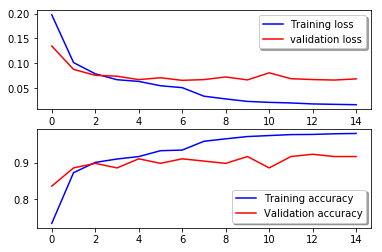

In [47]:
# Plot the loss and accuracy curves for training and validation for one DNN
index=np.random.randint(n_fold)

fig, ax = plt.subplots(2,1)
ax[0].plot(history[index].history['loss'], color='b', label="Training loss")
ax[0].plot(history[index].history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history[index].history['acc'], color='b', label="Training accuracy")
ax[1].plot(history[index].history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [48]:
#ensemble prediction for the test dataset
test_pred = np.zeros((X_test.shape[0], 2))  
for i in range(n_fold):
    pred = model[i].predict(X_test)
    test_pred = test_pred + np.array([[1,0] if ele<0.5 else [0,1] for ele in pred])

test_pred2 = np.argmax(test_pred, axis=1)

#show the evaluation scores for test dataset
evaluation_scores(Y_test, test_pred2)

confusion_matrix:
[[564  42]
 [ 54 514]]

SENS: 90.493 %
SPEC: 93.069 %
ACC : 91.823 %
F1 score: 0.915


Obviously, our 15 DNN model has better evaluation scores on test dataset for sensitivity, specifity, accuracy, and F1 score. 

## Make a prediction on an AMP derived from mouse BAX

Peptide Bax-α5 (Ac-DGNFNWGRVVALFYFASKLVLKALSTKVPELIRT-NH2) was derived from the pore-forming (α5 and part of α6 hairpin) domain (residues 102–135) of mouse Bax [(Shuo et al.)](https://www.pnas.org/content/105/45/17379)  Let's see if our 15 DNN model can correctly predict this peptide as an AMP. 

In [70]:
#pad X in front of peptide sequence to make its length 200
test_str = 'DGNFNWGRVVALFYFASKLVLKALSTKVPELIRT'
while len(test_str)<200:
    test_str='X'+test_str

#mapping 21 different amino acid to 21 intergers:
test_str2 = []
for j in range(len(test_str)):
    test_str2.append(mapping[test_str[j]])
test_str2 = pd.DataFrame(test_str2).T

In [71]:
#make prediction on AMP derived from BAX
test_pred = np.zeros((test_str2.shape[0], 2)) 
for i in range(n_fold):
    pred = model[i].predict(test_str2)
    test_pred = test_pred + np.array([[1,0] if ele<0.5 else [0,1] for ele in pred])

test_pred2 = np.argmax(test_pred, axis=1)

#prediction result
if test_pred2[0]==1:
    print('Peptide derived from BAX is an AMP, and our prediction indicates it is.')
else:
    print('Peptide derived from BAX is an AMP, and our prediction indicates it is not.')

Peptide derived from BAX is an AMP, and our prediction indicates it is.


## Conclusion
Our first goal is achieved by building a 15 DNN model to reconigze AMP peptides with accuracy >91% on unseen test dataset. The next step of is work is to further classify the pore-forming mechanism (Toroidal vs. Barrel Stave Model) if a given peptide is recoginized as AMP. 

### Reference:
[Deep learning improves antimicrobial peptide recognition](https://doi.org/10.1093/bioinformatics/bty179), 
Daniel Veltri, Uday Kamath, and Amarda Shehu, 
Bioinformatics, Volume 34, Issue 16, 15 August 2018, Pages 2740–2747
